# 随机森林
随机森林是一种经典的集成学习模型，其弱分类器为决策树模型。为了保证模型的泛化能力，随机森林在构建每个决策树时，往往会遵循“数据随机”和“特征随机”两个基本原则<p>
数据随机是指从所有数据中有放回地随机抽取数据作为其中一个决策树模型地训练数据，例如，有1000个原始数据，有放回地抽取800次，构成一组新的数据，用于训练某一个决策树模型。<p>
特征随机是指如果每个样本的特征维度为M，指定一个常数k \< M，每次构建决策树时，随机地从M个特征中选择k个特征，一般默认k \= sqrt(M) .<p>
随机森林模型集成了多个决策树，预测结果更准确，且通过数据随机和特征随机的方式，降低了过拟合的可能性，泛化性能更强
随机森林sklearn文档https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

本节课将利用股票数据进行教学演示，将用到用于获取股价数据的Tushare库，可通过<p>
(1)在Anaconda Prompt中输入 pip install tushare 按回车 <p>
(2)在Jupyter Notebook 的cell中输入 !pip install tushare 并运行该cell 任选其一进行安装。<p>
   为加快安装速度，可以在安装前先添加清华镜像源<p>
在Anaconda Prompt中依次输入<p>
conda config --add channels http://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/free/<p>
conda config --add channels http://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/conda-forge <p>
conda config --set show_channel_urls yes<p>
同时也要用到计算股票衍生变量的库TA-Lib, 如果是64位的Windows操作系统，直接运行“pip install talib”命令来安装TA-Lib库会报错，原因在于Python pip源中的TA-Lib是32位的，不能安装在64位系统上。正确的方法是下载64位的安装包后进行本地安装。 首先需查看自己的Python的版本号，在Anaconda Prompt中输入python并按回车。可查看自己Python的版本，输入exit()回车退出命令行运行，打开网址 https://www.lfd.uci.edu/~gohlke/pythonlibs/  进入网页后按Ctrl+F键，搜索ta-lib,根据Python版本和自己操作系统的种类、位数选择合适的安装包下载。助教演示所用的包为“TA_Lib-0.4.24-cp39-cp39-win_amd64.whl”（适配py3.7  3.8  3.9版本64位windows操作系统的安装包在课前发的压缩包里有，其他版本的需要自行下载），下载完成后，进入存储该安装包的文件夹，复制文件名后，在路径栏输入cmd回车，在弹出的窗口输入pip install TA_Lib-0.4.24-cp39-cp39-win_amd64.whl 回车进行安装，之后运行python回车import talib回车，不报错说明安装成功,若报错，很可能是由于numpy的版本不匹配导致的，可以用conda list numpy命令查看numpy版本，之后用conda install numpy=1.16.1安装指定numpy版本，解决此问题

In [1]:
import tushare as ts  # 股票基本数据相关库
import numpy as np  # 科学计算相关库
import pandas as pd  # 科学计算相关库  
import talib  # 股票衍生变量数据相关库
import matplotlib.pyplot as plt  # 引入绘图相关库
from sklearn.ensemble import RandomForestClassifier  # 引入分类决策树模型
from sklearn.metrics import accuracy_score  # 引入准确度评分函数
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息，警告非报错，不影响代码执行

In [2]:
# 1.股票基本数据获取
df = ts.get_k_data('000002',start='2015-01-01',end='2019-12-31')
df = df.set_index('date')  # 设置日期为索引
print(df)
# 2.简单衍生变量构造
df['close-open'] = (df['close'] - df['open'])/df['open']
df['high-low'] = (df['high'] - df['low'])/df['low']

df['pre_close'] = df['close'].shift(1)  # 该列所有往下移一行形成昨日收盘价
df['price_change'] = df['close']-df['pre_close']
df['p_change'] = (df['close']-df['pre_close'])/df['pre_close']*100

# 3.移动平均线相关数据构造
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()
df.dropna(inplace=True)  # 删除空值

# 4.通过Ta_lib库构造衍生变量
df['RSI'] = talib.RSI(df['close'], timeperiod=12)  # 相对强弱指标
df['MOM'] = talib.MOM(df['close'], timeperiod=5)  # 动量指标
df['EMA12'] = talib.EMA(df['close'], timeperiod=12)  # 12日指数移动平均线
df['EMA26'] = talib.EMA(df['close'], timeperiod=26)  # 26日指数移动平均线
df['MACD'], df['MACDsignal'], df['MACDhist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD值
df.dropna(inplace=True)  # 删除空值

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
              open   close    high     low     volume    code
date                                                         
2015-01-05   7.200   7.720   8.100   7.030  6560835.0  000002
2015-01-06   7.410   7.170   7.800   6.860  3346346.0  000002
2015-01-07   7.070   7.040   7.310   6.810  2642051.0  000002
2015-01-08   7.130   6.400   7.180   6.270  2639394.0  000002
2015-01-09   6.350   6.260   7.030   6.100  3294584.0  000002
...            ...     ...     ...     ...        ...     ...
2019-12-25  27.165  27.055  27.395  26.945   685037.0  000002
2019-12-26  27.265  27.885  28.065  27.265   888790.0  000002
2019-12-27  27.995  27.765  28.085  27.575   703096.0  000002
2019-12-30  28.115  28.335  28.555  27.785   915751.0  000002
2019-12-31  28.115  28.945  29.215  28.085   663497.0  000002

[1084 rows x 6 columns]


查看此时的df后五行

In [3]:
df.tail()

,open,close,high,low,volume,code,close-open,high-low,pre_close,price_change,p_change,MA5,MA10,RSI,MOM,EMA12,EMA26,MACD,MACDsignal,MACDhist
date,,,,,,,,,,,,,,,,,,,,
2019-12-25,27.165,27.055,27.395,26.945,685037.0,000002,-0.004049,0.016701,27.145,-0.09,-0.331553,27.643,26.840,63.081344,-0.02,26.673555,25.737103,0.936452,0.774585,0.161867
2019-12-26,27.265,27.885,28.065,27.265,888790.0,000002,0.022740,0.029342,27.055,0.83,3.067825,27.661,27.152,68.895291,0.09,26.859932,25.896207,0.963725,0.812413,0.151311
2019-12-27,27.995,27.765,28.085,27.575,703096.0,000002,-0.008216,0.018495,27.885,-0.12,-0.430339,27.525,27.437,67.225542,-0.68,26.999173,26.034636,0.964537,0.842838,0.121699
2019-12-30,28.115,28.335,28.555,27.785,915751.0,000002,0.007825,0.027713,27.765,0.57,2.052944,27.637,27.649,70.882335,0.56,27.204685,26.205033,0.999651,0.874201,0.125451
2019-12-31,28.115,28.945,29.215,28.085,663497.0,000002,0.029522,0.040235,28.335,0.61,2.152815,27.997,27.822,74.238064,1.80,27.472426,26.407994,1.064432,0.912247,0.152185


准备好原始数据后，接着来提取特征变量和目标变量

In [4]:
X = df[['close', 'volume', 'close-open', 'MA5', 'MA10', 'high-low', 'RSI', 'MOM', 'EMA12', 'MACD', 'MACDsignal', 'MACDhist']]
y = np.where(df['price_change'].shift(-1)> 0, 1, -1)

注意：是**今天的股价信息预测下一天的股价涨跌情况** ，所以 **y是下一天的股价变化情况**。

其中Numpy库中的where()函数的使用方法如下所示：
np.where(判断条件,满足条件的赋值,不满足条件的赋值)

其中df['price_change'].shift(-1)则是利用shift()函数将price_change（股价变化）这一列往上移动一行，这样就获得了每一行对应的下一天股价涨跌情况。

**训练集和测试集数据划分**<p>
接下来，我们要将原始数据集进行分割，我们要注意到一点，训练集与测试集的划分要按照时间序列划分，而不是像之前利用train_test_split()函数进行划分。原因在于股票价格的变化趋势具有时间性，如果我们随机划分，则会破坏时间性特征，因为我们是根据当天数据来预测下一天的股价涨跌情况，而不是任意一天的股票数据来预测下一天的股价涨跌情况。
因此，我们将前90%的数据作为训练集，后10%的数据作为测试集，代码如下：

In [5]:
X_length = X.shape[0]  # shape属性获取X的行数和列数，shape[0]即表示行数 
split = int(X_length * 0.9)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**模型搭建**

In [6]:
model = RandomForestClassifier(max_depth=3, n_estimators=10, min_samples_leaf=10, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=10, n_estimators=10,
                       random_state=1)

**模型使用与评估**

In [7]:
y_pred = model.predict(X_test)
a = pd.DataFrame()  # 创建一个空DataFrame 
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,-1,-1
1,1,-1
2,-1,-1
3,1,-1
4,1,1


In [8]:
score = accuracy_score(y_pred, y_test)
print(score)

0.5428571428571428


In [9]:
# 通过如下代码可以更好的展示特征及其特征重要性：
features = X.columns  
importances = model.feature_importances_
a = pd.DataFrame()
a['特征'] = features
a['特征重要性'] = importances
a = a.sort_values('特征重要性', ascending=False)
a

,特征,特征重要性
7,MOM,0.175600
0,close,0.151327
5,high-low,0.114476
1,volume,0.099577
10,MACDsignal,0.088661
4,MA10,0.079073
9,MACD,0.070617
3,MA5,0.065148
2,close-open,0.050215
8,EMA12,0.047133


In [10]:
#参数调优
from sklearn.model_selection import GridSearchCV  # 网格搜索合适的超参数
# 指定分类器中参数的范围
parameters = {'n_estimators':[5, 10, 20], 'max_depth':[2, 3, 4, 5], 'min_samples_leaf':[5, 10, 20, 30]}
new_model = RandomForestClassifier(random_state=1)  # 构建分类器
grid_search = GridSearchCV(new_model, parameters, cv=6, scoring='accuracy')  
# cv=6表示交叉验证6次，scoring='roc_auc'表示以ROC曲线的AUC评分作为模型评价准则, 默认为'accuracy', 即按准确度评分

grid_search.fit(X_train, y_train)  # 传入数据
print(grid_search.best_params_, grid_search.best_score_) # 输出参数的最优值和此时对应的准确率

{'max_depth': 2, 'min_samples_leaf': 20, 'n_estimators': 10} 0.534739234579999


# AdaBoost
AdaBoost算法（Adaptive Boosting）是一种有效而实用的Boosting算法，它以一种高度自适应的方式按顺序训练弱学习器。针对分类问题，AdaBoost算法根据前一次的分类效果调整数据的权重，在上一个弱学习器中分类错误的样本的权重会在下一个弱学习器中增加，分类正确的样本的权重则相应减少，并且在每一轮迭代时会向模型加入一个新的弱学习器。不断重复调整权重和训练弱学习器，直到误分类数低于预设值或迭代次数达到指定最大值，最终得到一个强学习器。简单来说，AdaBoost算法的核心思想就是调整错误样本的权重，进而迭代升级。
sklearn的Adaboost文档：https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier
## AdaBoost算法案例实战：信用卡精准营销模型
本节要运用AdaBoost分类模型搭建一个信用卡精准营销模型，帮助大家巩固之前所学的知识,运用AdaBoost解决实际问题。

In [11]:
import pandas as pd
df = pd.read_excel('信用卡精准营销模型.xlsx')
df.head()

,年龄,月收入（元）,月消费（元）,性别,月消费/月收入,响应
0,30,7275,6062,0,0.833265,1
1,25,17739,13648,0,0.769378,1
2,29,25736,14311,0,0.556069,1
3,23,14162,7596,0,0.536365,1
4,27,15563,12849,0,0.825612,1


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
X = df.drop(columns='响应') 
y = df['响应']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

clf = AdaBoostClassifier(random_state=123)
clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=123)

In [13]:
y_pred = clf.predict(X_test)
a = pd.DataFrame()  # 创建一个空DataFrame 
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,1,1
1,1,1
2,1,1
3,0,0
4,1,1


In [14]:
# 查看预测准确度
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

0.85


In [15]:
# 查看预测分类概率
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba[0:5]  # 查看前5项，第一列为分类为0的概率，第二列为分类为1的概率

array([[0.19294615, 0.80705385],
       [0.41359387, 0.58640613],
       [0.42597039, 0.57402961],
       [0.66817389, 0.33182611],
       [0.32850159, 0.67149841]])

ROC曲线全称为受试者工作特征曲线，横坐标为 FPR（假阳性率）= FP /（FP + TN）即负类数据被分为正类的比例，纵坐标为TPR（真阳性率）= TP /（TP + FN），即正类数据被分为正类的比例。对于样本数据，我们使用分类器对其进行分类，分类器会给出每个数据为正例的概率，我们可以针对此来设定一个阈值，当某个sample被判断为正例的概率大于这个阈值时，认为该sample为正例，小于则为负例，然后通过计算我们就可以得到一个(TPR , FPR)对，即图像上的一个点，我们通过不断调整这个阈值，就得到若干个点，从而画出一条曲线。一定过(0,0)和(1,1)

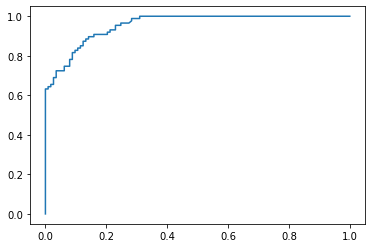

In [16]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thres = roc_curve(y_test.values, y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.show()

In [17]:
# 查看AUC值
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, y_pred_proba[:,1])
print(score)

0.9559047909673483


In [18]:
# 查看特征重要性
clf.feature_importances_

array([0.18, 0.2 , 0.36, 0.02, 0.24])

In [19]:
# 通过DataFrame的方式展示特征重要性
features = X.columns  # 获取特征名称
importances = clf.feature_importances_  # 获取特征重要性

# 通过二维表格形式显示
importances_df = pd.DataFrame()
importances_df['特征名称'] = features
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征名称,特征重要性
2,月消费（元）,0.36
4,月消费/月收入,0.24
1,月收入（元）,0.20
0,年龄,0.18
3,性别,0.02
